# Numerical methods project
*This Notebook has been created by Clément Caillaud*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from scipy.sparse import diags
from time import process_time

plt.rc('font',serif='Times', family='serif', weight='normal')

params = {
   'axes.labelsize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': (6,4),
   'figure.dpi': 100
   }
plt.rcParams.update(params)

## The 1D diffusion equation

We consider here the diffusion of a scalar $\phi(t,x)$ in a domain $\Omega$ closed by periodic boundaries $\partial \Omega$. We aim to study the effect of the discretized equation implicitation on the solving time and efficiency.

$$\frac{\partial \phi}{\partial t} - \alpha\frac{\partial^2 \phi}{\partial x^2} = 0 $$

The scalar initial distribution $\phi_0(t=0,x)$ is advected through the domain 10 times and the diffusion and dispersion errors of the numerical methods are assessed.

In [2]:
Nx = 512
ng = 2
x_min = -1.0
x_max = np.abs(x_min)
a  = 2.0
d = 1e-3


x = np.linspace(x_min, x_max, Nx)
dx = np.abs(np.diff(x))
t_max = 800

cfl = 0.1
Fo = 0.2
dt = Fo * dx[0]**2 / d

i_s = 2
i_e = Nx+ng
dt

0.0030637137572236623

### Initial solution

We define here $\phi_0=\phi(t=0,x)$. Any periodic initial distribution can be chosen.

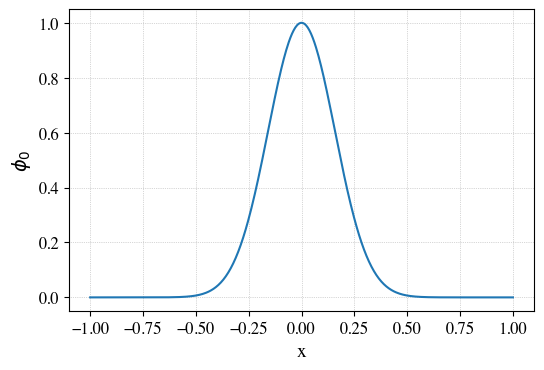

In [3]:
#Initial solution array
phi_0 = np.exp(-x**2/0.05)

plt.figure(dpi=100)
plt.plot(x, phi_0);
plt.grid(linewidth=0.5, linestyle=':')
plt.xlabel(r'x');
plt.ylabel(r'$\phi_0$');

In [4]:
#Creating ghost-cells for easy BC integration
ng_r = np.zeros(ng)
ng_l = np.zeros(ng)

phi_0 = np.concatenate((ng_l, phi_0, ng_r))
print(phi_0[i_s:i_e].shape, x.shape)

#Building the necessary additional arrays
phi = phi_0.copy()
phi_n = phi.copy() * 0.0

(512,) (512,)


### Building the implicit problem

In [5]:
low_diag = np.ones(Nx+1)
diag = -2.0*np.ones(Nx+ng)
up_diag = np.ones(Nx+1)

#Conditionnning ghost-cells to zero
up_diag[0] = 0.0
low_diag[-1] = 0.0
diag[0] = 0.0
diag[-1] = 0.0

#Building the differentiation matrix Dx
Dx = diags((low_diag, diag, up_diag), (-1,0,1))
Dx = Dx.toarray()

#Simple identity matrix accounting for ghost-cells
Id = np.eye(Nx+ng)

#Building the scheme operator A
A = (Id - (d*dt/dx[0]**2) * Dx)
print(A)

[[ 1.   0.   0.  ...  0.   0.   0. ]
 [-0.2  1.4 -0.2 ...  0.   0.   0. ]
 [ 0.  -0.2  1.4 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  1.4 -0.2  0. ]
 [ 0.   0.   0.  ... -0.2  1.4 -0.2]
 [ 0.   0.   0.  ...  0.   0.   1. ]]


### Routines definition
Here are defined the functions dedicated to the different numerical schemes considered. Especially the boundary conditions and the spatial scheme $f(\phi^n)$

In [6]:
#Quick Dirichlet BC applied to the ghost-cells and boundaries
def bc_dirichlet(phi):
    phi[0:i_s+1] = 0.0
    phi[i_e-1:Nx+2*ng+1] = 0.0
    
    return phi

#@jit(nopython=True) #Directive for just-in-time compilation of intensive python loop (can be suppressed)
def explicit_scheme(phi_n,phi,a,dt,dx,imin,imax):
    for i in range(imin, imax+1):
        phi_n[i] = phi[i] + dt * d * (phi[i+1] - 2.0*phi[i] + phi[i-1]) / (dx**2) #+ ((a*dt)**2/(2*dx**2))*(phi[i+1] - 2.0*phi[i] + phi[i-1])
    
    return phi_n

#@jit(nopython=True)
def implicit_scheme(phi_n,phi,A):
    phi_n[i_s-1:i_e+1] = np.linalg.solve(A, phi[i_s-1:i_e+1])
    
    return phi_n

#Utility function to check eventual divergence in the computation
def divergence(phi):
    divergence = False
    if np.NAN in phi : divergence = True
    if np.inf in phi : divergence = True
    
    return divergence

### Solver loop
We are solving the discretized equation with the temporal and spatial schemes, giving : $\phi^{n+1} = f(\phi^n)$. 

The boundary conditions are applied and the physical time is monitored

In [7]:
t = 0.0
ite = 0

t1_start = process_time()
while t < t_max :
    
    #Ensuring a clean phi_n
    phi_n[:] = 0.0
    
    #Applying BC's
    bc_dirichlet(phi)
    
    #Update physical time
    if t+dt>t_max:
        dt = np.abs(t_max - t)
    else :
        t = t + dt
    
    #Compute the n+1 state of phi
    #implicit_scheme(phi_n, phi, A)
    explicit_scheme(phi_n, phi, d, dt, dx=dx[0], imin=i_s, imax=i_e)
    
    phi[:] = phi_n[:]
    
    if(divergence(phi)): 
        print ('Solution diverged')
        break
        
        
    ite +=1

t1_end = process_time()

t, dt, ite, t1_end-t1_start

(800.0, 0.00306371262081484, 261122, 183.892111)

### Computed solution

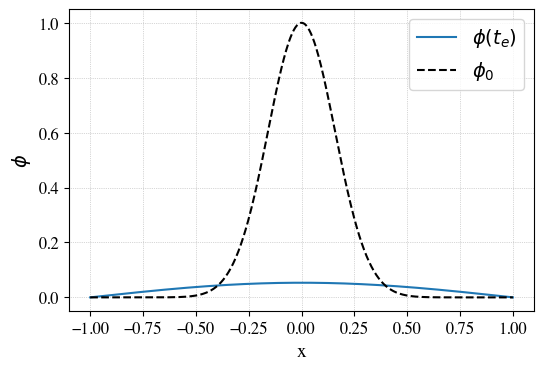

In [8]:
plt.plot(x, phi[i_s:i_e], label=r'$\phi(t_e)$')
plt.plot(x, phi_0[i_s:i_e], 'k--', label=r'$\phi_0$')
plt.grid(linewidth=0.5, linestyle=':')
plt.xlabel(r'x')
plt.ylabel(r'$\phi$')
plt.legend()